In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

import nltk
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
#from bs4 import BeautifulSoup
import re,string,unicodedata
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,f1_score
from sklearn.model_selection import train_test_split
from string import punctuation
from nltk import pos_tag
from nltk.corpus import wordnet


import keras
import tensorflow as tf
#import tensorflow_hub as hub
from tensorflow import keras 
from keras import backend as K
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from keras.layers import LSTM,Dense,Bidirectional,Input
from keras.models import Model
import torch
import transformers

2023-03-10 11:53:33.996410: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-10 11:53:33.996456: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/home/antonio/.pyenv/versions/3.10.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import platform

os = platform.system()

match os.lower():
    case "darwin":
        path = "/Users/antoniobaio/Desktop/Progetti/ProgettiDS//BERT/IMDB.csv"
    case "linux":
        path = "/home/antonio/Scrivania/ProgettiDS/BERT/IMDB.csv"
    case "windows":
        path = "AGGIUNGI PATH"
        
print("Actual path: " + path)

Actual path: /home/antonio/Scrivania/ProgettiDS/BERT/IMDB.csv


In [4]:
#verificare la disponibilità di cuda
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [93]:
df = pd.read_csv(path)
df.head(15)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


In [94]:
def cat2num(value):
    if value=='positive': 
        return 1
    else: 
        return 0
    
df['sentiment']  =  df['sentiment'].apply(cat2num)
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1
...,...,...
49995,I thought this movie did a down right good job...,1
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",0
49997,I am a Catholic taught in parochial elementary...,0
49998,I'm going to have to disagree with the previou...,0


In [95]:
#shuffle del dataset
df = df.sample(frac=1, random_state=42)
df

,review,sentiment
33553,I really liked this Summerslam due to the look...,1
9427,Not many television shows appeal to quite as m...,1
199,The film quickly gets to a major chase scene w...,0
12447,Jane Austen would definitely approve of this o...,1
39489,Expectations were somewhat high for me when I ...,0
...,...,...
11284,`Shadow Magic' recaptures the joy and amazemen...,1
44732,I found this movie to be quite enjoyable and f...,1
38158,Avoid this one! It is a terrible movie. So wha...,0
860,This production was quite a surprise for me. I...,1


In [96]:
from nltk.corpus import stopwords
nltk.download('stopwords')
sw = stopwords.words('english')

def clean_text(text):
    
    text = text.lower()
    
    text = re.sub(r"[^a-zA-Z?.!,¿]+", " ", text) #Comando che permette di cambiare tutti i caratteri tranne :a-z, A-Z, ".", "?", "!", "," con uno spazio 

    text = re.sub(r"http\S+", "",text) #Rimozione dei link 
    
    html=re.compile(r'<.*?>') 
    
    text = html.sub(r'',text) #Rimozione dei tag HTML
    
    punctuations = '@#!?+&*[]-%.:/();$=><|{}^' + "'`" + '_'
    for p in punctuations:
        text = text.replace(p,'') #Comando che permette di rimuovere i segni definiti sopra come punteggiatura
        
    text = [word.lower() for word in text.split() if word.lower() not in sw]
    
    text = " ".join(text) #Rimozione di tutte le stopword
    
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F" 
                           u"\U0001F300-\U0001F5FF"  
                           u"\U0001F680-\U0001F6FF"  
                           u"\U0001F1E0-\U0001F1FF"  
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text) #Comando che rimuove quelle definite sopra come emojis
    
    return text

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/antonio/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [97]:
df['review'] = df['review'].apply(lambda x: clean_text(x))
df.head()

,review,sentiment
33553,"really liked summerslam due look arena, curtai...",1
9427,many television shows appeal quite many differ...,1
199,film quickly gets major chase scene ever incre...,0
12447,jane austen would definitely approve one br br...,1
39489,"expectations somewhat high went see movie, tho...",0


In [98]:
df['review'] = df['review'].str.replace(r'\bbr\b', '')

/tmp/ipykernel_3431/4216776083.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df['review'] = df['review'].str.replace(r'\bbr\b', '')


In [73]:
sns.set(style = "white" , font_scale = 1.2)

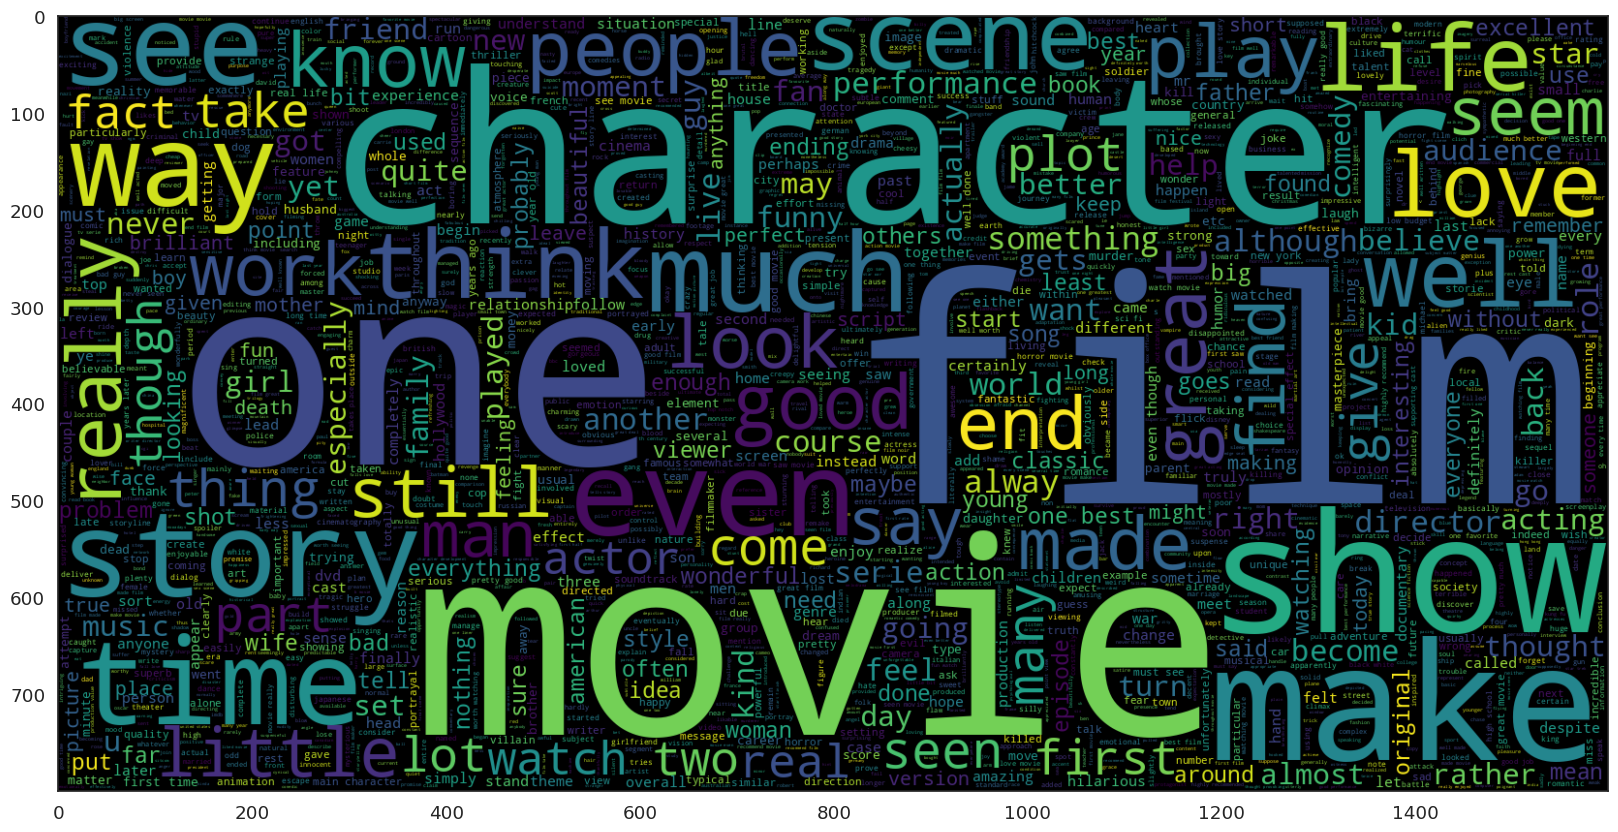

In [74]:
plt.figure(figsize = (20,20)) # Positive Review Text
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.label == 1].review))
plt.imshow(wc , interpolation = 'bilinear')

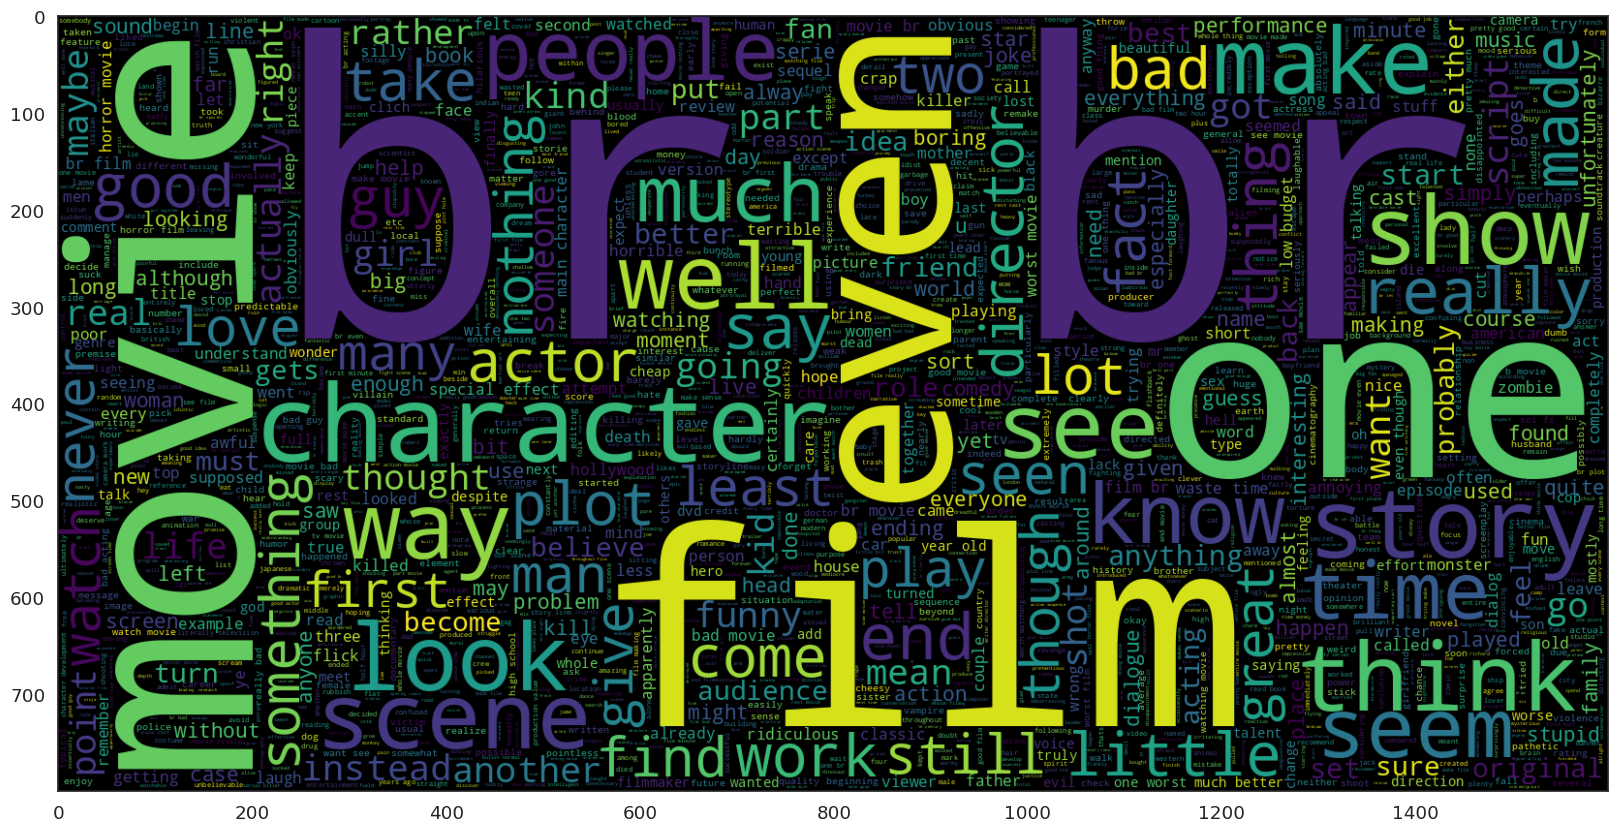

In [32]:
plt.figure(figsize = (20,20)) # Negative Review Text
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.label == 0].review))
plt.imshow(wc , interpolation = 'bilinear')

In [99]:
def get_corpus(text):
    words = []
    for i in text:
        for j in i.split():
            words.append(j.strip())
    return words
corpus = get_corpus(df.review)
corpus[:5]

['really', 'liked', 'summerslam', 'due', 'look']

In [100]:
from collections import Counter
counter = Counter(corpus)
most_common = counter.most_common(10)
most_common = dict(most_common)
most_common

{'movie': 79181,
 'film': 71187,
 'one': 51757,
 'like': 39526,
 'good': 27555,
 ',': 26981,
 'even': 24688,
 'would': 24532,
 'see': 22471,
 'really': 22411}

In [101]:
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import InputExample, InputFeatures

model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [102]:
example='In this notebook, I will do sentiment analysis using BERT with Huggingface'
tokens=tokenizer.tokenize(example)
token_ids = tokenizer.convert_tokens_to_ids(tokens)
print(tokens)
print(token_ids)

['in', 'this', 'notebook', ',', 'i', 'will', 'do', 'sentiment', 'analysis', 'using', 'bert', 'with', 'hugging', '##face']
[1999, 2023, 14960, 1010, 1045, 2097, 2079, 15792, 4106, 2478, 14324, 2007, 17662, 12172]


In [103]:
train = df[:45000]
test = df[45000:]

In [104]:
def convert_data_to_examples(train, test, review, sentiment): 
    train_InputExamples = train.apply(lambda x: InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
                                                          text_a = x[review], 
                                                          label = x[sentiment]), axis = 1)

    validation_InputExamples = test.apply(lambda x: InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
                                                          text_a = x[review], 
                                                          label = x[sentiment]), axis = 1,)
  
    return train_InputExamples, validation_InputExamples

train_InputExamples, validation_InputExamples = convert_data_to_examples(train,  test, 'review',  'sentiment')

train_InputExamples[0]

InputExample(guid=None, text_a='one reviewers mentioned watching oz episode hooked right, exactly happened   first thing struck oz brutality unflinching scenes violence, set right word go trust me, show faint hearted timid show pulls punches regards drugs, sex violence hardcore, classic use word   called oz nickname given oswald maximum security state penitentary focuses mainly emerald city, experimental section prison cells glass fronts face inwards, privacy high agenda em city home manyaryans, muslims, gangstas, latinos, christians, italians, irish moreso scuffles, death stares, dodgy dealings shady agreements never far away   would say main appeal show due fact goes shows dare forget pretty pictures painted mainstream audiences, forget charm, forget romanceoz mess around first episode ever saw struck nasty surreal, say ready it, watched more, developed taste oz, got accustomed high levels graphic violence violence, injustice crooked guards sold nickel, inmates kill order get away it

In [106]:
from tqdm import tqdm

def convert_examples_to_tf_dataset(examples, tokenizer, max_length=128):
    features = [] # -> will hold InputFeatures to be converted later

    for e in tqdm(examples):
        input_dict = tokenizer.encode_plus(
            e.text_a,
            add_special_tokens=True,    # Add 'CLS' and 'SEP'
            max_length=max_length,    # truncates if len(s) > max_length
            return_token_type_ids=True,
            return_attention_mask=True,
            pad_to_max_length=True, # pads to the right by default # CHECK THIS for pad_to_max_length
            truncation=True
        )

        input_ids, token_type_ids, attention_mask = (input_dict["input_ids"],input_dict["token_type_ids"], input_dict['attention_mask'])
        features.append(InputFeatures( input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, label=e.label) )

    def gen():
        for f in features:
            yield (
                {
                    "input_ids": f.input_ids,
                    "attention_mask": f.attention_mask,
                    "token_type_ids": f.token_type_ids,
                },
                f.label,
            )

    return tf.data.Dataset.from_generator(
        gen,
        ({"input_ids": tf.int32, "attention_mask": tf.int32, "token_type_ids": tf.int32}, tf.int64),
        (
            {
                "input_ids": tf.TensorShape([None]),
                "attention_mask": tf.TensorShape([None]),
                "token_type_ids": tf.TensorShape([None]),
            },
            tf.TensorShape([]),
        ),
    )


DATA_COLUMN = 'review'
LABEL_COLUMN = 'sentiment'

In [109]:
train_data = convert_examples_to_tf_dataset(list(train_InputExamples), tokenizer)
train_data = train_data.shuffle(100).batch(32).repeat(1)

100%|██████████| 45000/45000 [02:37<00:00, 286.55it/s]


In [110]:
validation_data = convert_examples_to_tf_dataset(list(validation_InputExamples), tokenizer)
validation_data = validation_data.batch(32)

100%|██████████| 5000/5000 [00:17<00:00, 287.94it/s]


In [1]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08, clipnorm=1.0), 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy('accuracy')])

model.fit(train_data, epochs=2, validation_data=validation_data)

NameError: name 'model' is not defined

In [86]:
# definisco la percentuale di campioni da includere nel train_set
train_size = 0.75

# calcolo il numero di campioni da includere nel train_set e nel test_set
train_len = int(len(df) * train_size)
test_len = len(df) - train_len

# estraggo in modo casuale i campioni da includere nel train_set
train_df = df.sample(n=train_len, random_state=42)

# escludo dal test_set i campioni presenti nel train_set
test_df = df.drop(train_df.index)

print('train lenght:',len(train_df))
print(train_df.groupby(['class_index'])['review'].count())
print('test lenght:',len(test_df))
print(test_df.groupby(['class_index'])['review'].count())

print("Train set:")
print(train_df.head())
print("Test set:")
print(test_df.head())


train lenght: 37500
class_index
0    18872
1    18628
Name: review, dtype: int64
test lenght: 12500
class_index
0    6128
1    6372
Name: review, dtype: int64
Train set:
                                                  review sentiment  \
19398  disgusting joke supposed moviefrom poster look...  negative   
21772  extremely bad one long train wreck last episod...  negative   
45259  tamara anderson family moving again, itinerant...  negative   
25972  number things correct, although important sinc...  positive   
28799  seems sensei seagal getting moralising less ac...  negative   

       class_index  
19398            0  
21772            0  
45259            0  
25972            1  
28799            0  
Test set:
                                                  review sentiment  \
5586   embarassmentthis doesnt justice original awful...  negative   
1433   end review cache, wrote intrigued haneke film ...  positive   
10119  name cult movie often given films continue scr...  negat

In [87]:
sentences = train_df.review
labels = list(train_df.class_index)

In [90]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [91]:
index=0
print(' Original: ', list(sentences)[index])
table = np.array([tokenizer.tokenize(list(sentences)[index]), 
                    tokenizer.convert_tokens_to_ids(tokenizer.tokenize(list(sentences)[index]))]).T
print(tabulate(table,headers = ['Tokens', 'Token IDs'],tablefmt = 'fancy_grid'))

 Original:  disgusting joke supposed moviefrom poster looked like cute movie disappointment heck male lead looks like old retarded retired reject cop cop tell man act go back copno screen presence show bare ass so, mel gibson,, hell put filmmaker business guy business making movie seriously doubt women gay men find attractive whoever cast film talent hack cast talent hacks lead great us white guys alway getting asian women ugly white guy dean cain brad pitt white boyfriend asian women like ugly white guys black guys see get must low self esteem br br hot girl act movie kate hollidaywhy one hot white chick among rest ugly asian chicks think hot act br br two actors movie host poetry end movie one hot white chick massage house tl young kate holliday leads movie br br asia character ridiculous looked like trying hard kind ghetto sexy black girlkey word trying br br gina act hot enough physically kind role need play character roles humble self presentation br br think actress gina hirazumi

In [92]:
max_len = 0
l=[]
for sent in list(sentences):

    #Tokenizza il testo e aggiunge i tokens `[CLS]` e `[SEP]`
    input_ids = tokenizer.encode(sent, add_special_tokens=True)

    #Aggiorna la lunghezza massima delle frasi presenti nel dataset
    l.append(len(input_ids))
    max_len = max(max_len, len(input_ids))

if max_len>512:
  max_len=512
avg_len=int(sum(l)/len(l))

print('Max sentence length: ', max_len)
print('Avg sentence length: ', avg_len)

Token indices sequence length is longer than the specified maximum sequence length for this model (537 > 512). Running this sequence through the model will result in indexing errors


Max sentence length:  512
Avg sentence length:  152


In [96]:
MAX_LEN = 128
#Tokenizza tutte le frasi e mappa i tokens con i loro IDs
input_ids = []
attention_masks = []

for sent in sentences:
    # Quello che `encode_plus` farà:
    #   1. Tokenizza la frase
    #   2. Aggiunge il token `[CLS]` all'inizio della frase
    #   3. Aggiunge il token `[SEP]` alla fine della frase
    #   4. Mappa il token con il loro ID
    #   5. Esegue il padding o tronca la frase affinche la sua lunghezza sia pari a `max_length`
    #   6. Crea le attention masks per il token [PAD]
    encoded_dict = tokenizer.encode_plus(
                        sent,                      
                        add_special_tokens = True,      #Aggiunge i tokens '[CLS]' e '[SEP]'
                        max_length = MAX_LEN,           #Setta la lunghezza massima
                        pad_to_max_length = True,       #Se necessaio esegue il padding
                        return_attention_mask = True,   #Costruisce le attn. masks
                        return_tensors = 'pt',          #Restituisce un tensore di pytorch
                   )
    
    #Aggiunge la frase codificata alla lista degli input   
    input_ids.append(encoded_dict['input_ids'])
    
    #E aggiunge le attention mask alla lista (semplice distinzione tra padding o meno)
    attention_masks.append(encoded_dict['attention_mask'])

#Converte la lista in un tensore
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

ImportError: Unable to convert output to PyTorch tensors format, PyTorch is not installed.